In [103]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
</style>
""")

# Descriptive Statistics and Handling Missing Data in Pose Data Sequences
This exercise descriptive statistics and managing missing data, particularly within a slightly intricate dataset comprising fixed-length skeleton data sequences. Moreover, it encompasses the evaluation of the efficacy of these methodologies.
The primary objective is to implement and scrutinize various techniques for managing absent data points, ensuring a comprehensive and unblemished dataset for subsequent analyses.
### Pose Data Overview
In the subsequent cell, the ground truth dataset is loaded alongside an identical yet noise-infused counterpart. This involves a 30-frame time series sequence, capturing human poses with each frame encompassing 25^2 features, namely the x and y coordinates for 25 skeletal joints. We'll generate 200 such sequences, forming a dataset with a shape of ( (200, 30, 25_2) ).
#### Handling Missing Values
From the ground truth dataset (`GT_poses`
), data has been intentionally omitted, thereby creating the `Noisy_poses`
 dataset wherein 30% of the original values have been randomly substituted with NaN values (`np.nan`
). The ensuing step involves implementing and evaluating varied strategies for dealing with these missing data points, ensuring the robustness of the eventual analyses derived from this dataset.

<article class="message">
    <div class="message-body">
        <strong>List of tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#filling_zeros">Task 1: Filling missing data - zeros</a>
            </li>
            <li>
            <a href="#mean_impute">Task 2: Mean imputer</a>
            </li>
            <li>
            <a href="#temp_interpolation">Task 3: Temporal interpolation</a>
            </li>
            <li>
            <a href="#evaluation">Task 4: Adjust data and evaluate</a>
            </li>
            <li>
            <a href="#method_comp">Task 5: Method comparison</a>
            </li>
            <li>
            <a href="#Mean">Task 6: Mean pose and pose sequence</a>
            </li>
            <li>
            <a href="#Correlation">Task 7: Correlation between features</a>
            </li>
        </ul>
    </div>
</article>



In [104]:
## Load the data 
# give a title - to this box
## import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme (handles most styling)
sns.set_theme(style="whitegrid")

# Optional: try to apply a Seaborn-like Matplotlib style if available
for candidate in ['seaborn-v0_8', 'seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'seaborn-darkgrid']:
    if candidate in plt.style.available:
        plt.style.use(candidate)
        break

# Set random seed for reproducibility
np.random.seed(42)


GT_poses  = np.load("data/Input_Poses.npy")
Noisy_poses = np.load('data/Noisy_poses.npy')

N,T,D,C = Noisy_poses.shape
GT_poses = GT_poses.reshape(N,T,D*C)
Noisy_poses = Noisy_poses.reshape(N,T,D*C)

Plotting functions are provided in the cell below. It is not required to understand or modify any of these functions to complete the exercise.


In [105]:
def limb_number_plot(s_pose_x,s_pose_y,n1,n2,c="red",label=None):
  if label is not None:
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0): 
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-",label=label)
  else:
    if (s_pose_x[n1]>0) and (s_pose_y[n1]>0):
       plt.plot(s_pose_x[n1], s_pose_y[n1],'*',color = c,label=label)
    if (s_pose_x[n2]>0) and (s_pose_y[n2]>0):
       plt.plot(s_pose_x[n2], s_pose_y[n2],'*',color = c,label=label)
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0):
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-")

def plot_single_pose(s_pose,c = "darkgreen",label=None,ds='body_25',c_head = 'red',head = True):
    
    s_pose_x=s_pose[::2]
    s_pose_y=s_pose[1::2]
    #torso/body
    limb_number_plot(s_pose_x,s_pose_y,2,5,c)
    if label is not None:

        limb_number_plot(s_pose_x,s_pose_y,9,12,c,label)
    else:
        limb_number_plot(s_pose_x,s_pose_y,9,12,c)
    limb_number_plot(s_pose_x,s_pose_y,2,9,c)
    limb_number_plot(s_pose_x,s_pose_y,5,12,c)

    #left arm (person facing away)
    limb_number_plot(s_pose_x,s_pose_y,2,3,c)
    limb_number_plot(s_pose_x,s_pose_y,3,4,c)

    #right arm
    limb_number_plot(s_pose_x,s_pose_y,5,6,c)
    limb_number_plot(s_pose_x,s_pose_y,6,7,c)

    #left leg / foot
    limb_number_plot(s_pose_x,s_pose_y,9,10,c)
    limb_number_plot(s_pose_x,s_pose_y,10,11,c)
    limb_number_plot(s_pose_x,s_pose_y,11,22,c)
    #right leg / foot
    limb_number_plot(s_pose_x,s_pose_y,12,13,c)
    limb_number_plot(s_pose_x,s_pose_y,13,14,c)
    limb_number_plot(s_pose_x,s_pose_y,14,19,c)

    # head
    if head:
        limb_number_plot(s_pose_x,s_pose_y,0,15,c)
        limb_number_plot(s_pose_x,s_pose_y,0,16,c)

        limb_number_plot(s_pose_x,s_pose_y,15,17,c)
        limb_number_plot(s_pose_x,s_pose_y,16,18,c)
    return True 

import math
import matplotlib.pyplot as plt

def plot_single_sequence(poses, pose_name='Poses', color='blue', max_cols=10):
    """
    Plot a sequence of skeleton poses (frames) in a grid layout.

    Parameters
    ----------
    poses : array-like
        Skeleton sequence data, shape (T, D).
    pose_name : str, optional
        Title prefix for each frame (default: 'Poses').
    color : str, optional
        Color of the skeleton (default: 'blue').
    max_cols : int, optional
        Maximum number of columns for subplots (default: 10).
    """
    T = len(poses)
    ncols = min(max_cols, max(1, T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(2.0 * ncols, 2.0 * nrows))
    fig.suptitle(
        'Ground truth' if pose_name.lower() in ('gt', 'ground truth') else pose_name,
        y=0.98,
        fontsize=16
    )

    # Flatten axes to simplify iteration
    if not isinstance(axes, (list, tuple, np.ndarray)):
        axes = np.array([axes])
    axes = axes.ravel()

    for i in range(T):
        ax = axes[i]
        plt.sca(ax)
        plot_single_pose(poses[i], c=color, head=False)  # assumes you have this defined
        ax.set_ylim(1, 0)
        ax.set_xlim(-1, 1)
        ax.set_title(f"{pose_name}{i}", fontsize=10)
        ax.axis('off')

    # Hide extra axes if any
    for j in range(T, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

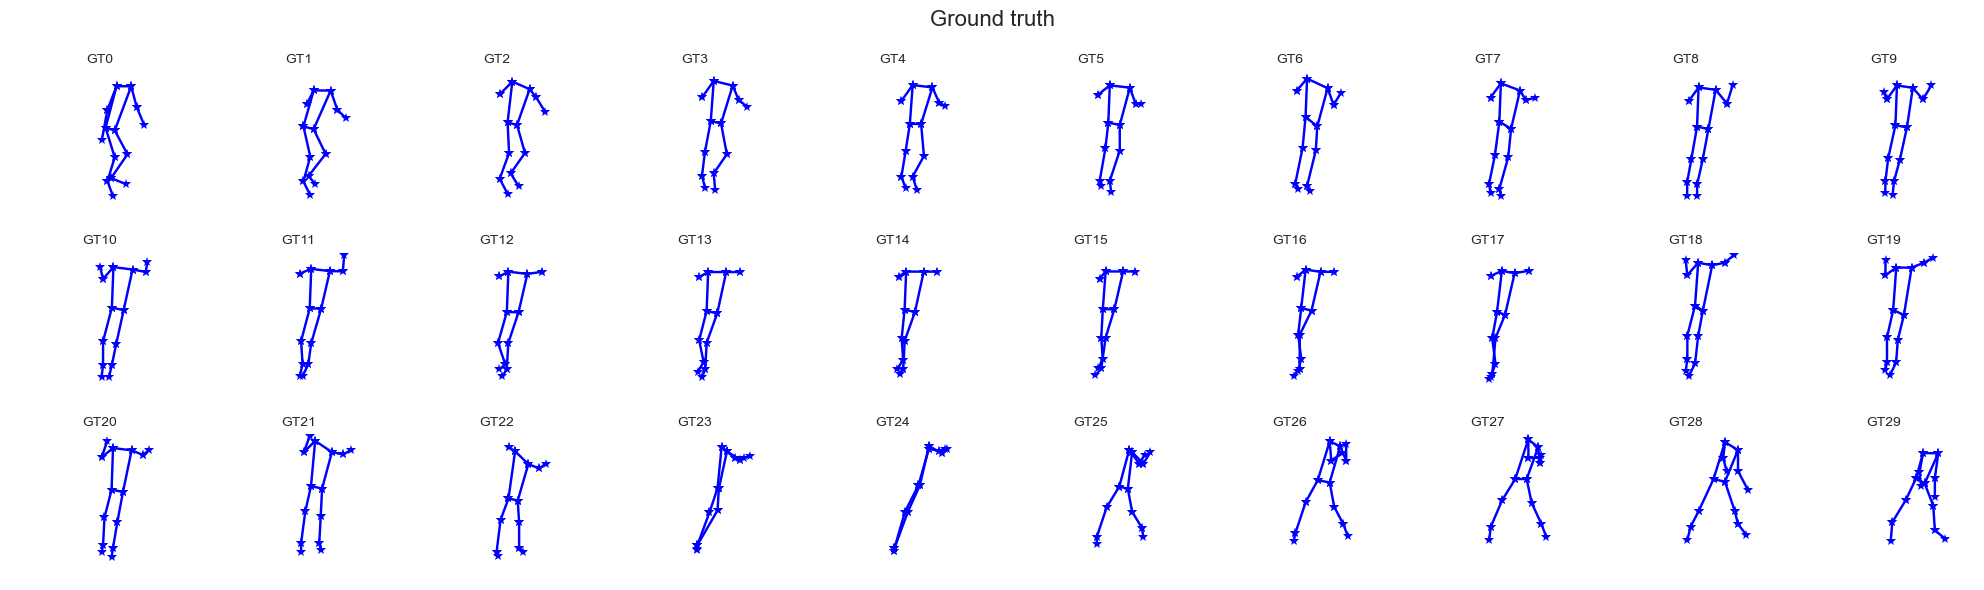

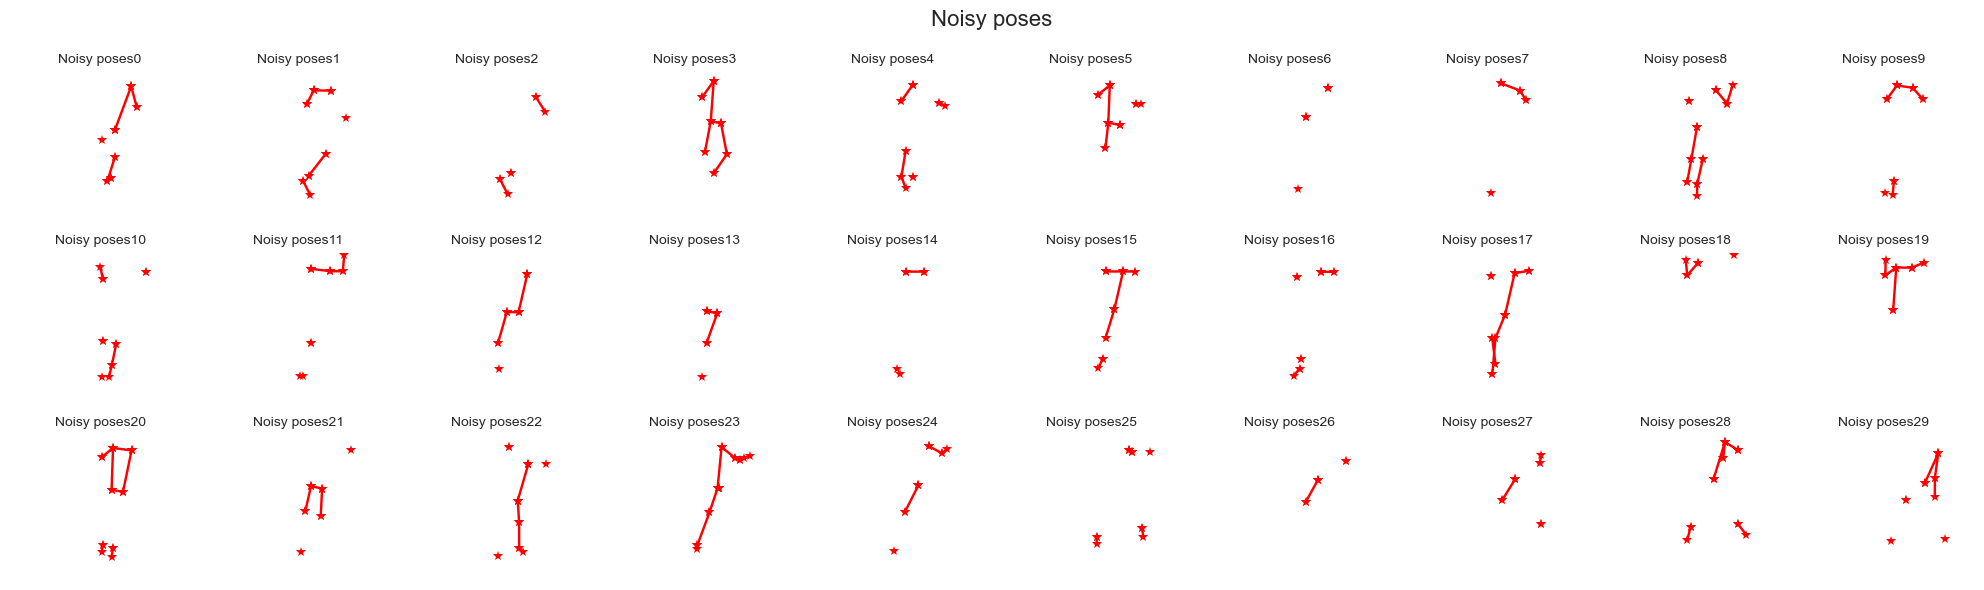

In [106]:
## Plot a random single sequence of both the noisy and ground truth skeleton data.
np.random.seed(12)
sample = np.random.randint(0,200)
plot_single_sequence(GT_poses[sample],pose_name='GT',color='blue')
plot_single_sequence(Noisy_poses[sample],pose_name='Noisy poses',color='red')

### Missing data strategies
In the following steps we will learn 3 different methods for handling missing data. 
1. Inserting zeros
2. Inserting means
3. Linear interpolation over time


---
**Task 1 (easy): Filling missing data - zeros👩‍💻**
Implement the first of 3 different methods for filling in missing data in the `Noisy_poses`
 in the cell below. The approach `filling_missing`
 should fill missing entries in the data sequences (`np.nan`
-values)with a zeros.
**Note:** (Hint: the function `np.isnan`
 can be used to find indices containing NaN values.)


---

In [107]:
## Method 1: Flling missing entries with 0s
def filling_missing(data, filling):
    """
    Fills missing entries in the given data with a specified value.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, seq_len, num_features) containing data entries.
    - filling (int or float): The value used to fill missing entries.

    Returns:
    - numpy.array: Data with missing entries filled using the specified value.
    """
    data_copy= data.copy()
    data_copy[np.isnan(data)] = filling
    return data_copy

#print(Noisy_poses)

print(filling_missing(Noisy_poses,0))

    

[[[0.00000000e+00 4.81841296e-02 3.06734190e-01 ... 7.44463488e-01
   0.00000000e+00 0.00000000e+00]
  [3.45025292e-01 1.78366392e-02 0.00000000e+00 ... 0.00000000e+00
   8.56498539e-02 7.41579955e-01]
  [3.13544582e-01 3.66413119e-02 2.76915806e-01 ... 8.29355975e-01
   9.24682303e-02 7.92576772e-01]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.19161920e-01
   0.00000000e+00 7.97222443e-01]
  [5.19570110e-01 2.07644100e-02 4.76980077e-01 ... 8.33349706e-01
   0.00000000e+00 8.11389662e-01]
  [4.42808182e-01 2.09868150e-02 0.00000000e+00 ... 8.64916157e-01
   0.00000000e+00 0.00000000e+00]]

 [[2.83146852e-01 1.74866465e-02 2.47243418e-01 ... 8.48000338e-01
   0.00000000e+00 7.95084330e-01]
  [2.71971570e-01 3.33931215e-02 0.00000000e+00 ... 8.33527457e-01
   3.41908108e-02 7.82579392e-01]
  [2.75501578e-01 3.46260737e-02 2.75437076e-01 ... 7.94370800e-01
   5.15257086e-02 7.76861324e-01]
  ...
  [8.07173345e-02 1.97644694e-02 1.19860196e-01 ... 0.00000000e+00
   2.19502


---
**Task 2 (medium): Mean imputer👩‍💻**
Implement the `mean_imputer`
 function below. The function should contain:
- Extract `data`
 shape and create a copy, `imputed_data`
, for imputation.

- Loop through each feature in `imputed_data`
.

- Compute the mean, identify `np.nan`
 indices, and replace them with the mean.

- Ensure `imputed_data`
 is returned, with all `np.nan`
 entries imputed.



---

In [108]:
## Method 2: Mean impute
def mean_imputer(data):
    """
    Imputes missing entries in the given data using the mean value of the features.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, sequence_len, num_features) containing data entries.

    Returns:
    - numpy.array: Data with missing entries imputed using the mean value.
    """
    # Extract data shape and create a copy for imputation
    num_samples, sequence_len, num_features = data.shape
    imputed_data = data.copy()

    # Loop through each of the features
    for feature_idx in range(num_features):
        # Extract the feature across all samples and sequences
        feature_data = imputed_data[:, :, feature_idx]
        
        # Compute the mean (ignoring NaN values)
        feature_mean = np.nanmean(feature_data)
        
        # Identify np.nan indices
        nan_mask = np.isnan(feature_data)
        
        # Replace NaN entries with the mean
        imputed_data[:, :, feature_idx] = np.where(nan_mask, feature_mean, feature_data) 
        # i.e. Where nan_mask is True (i.e., where there are NaNs), use feature_mean; otherwise, keep the original feature_data
    
    return imputed_data
print(mean_imputer(Noisy_poses))

[[[2.28630462e-01 4.81841296e-02 3.06734190e-01 ... 7.44463488e-01
   1.24205380e-01 8.21577740e-01]
  [3.45025292e-01 1.78366392e-02 2.25761632e-01 ... 8.40028402e-01
   8.56498539e-02 7.41579955e-01]
  [3.13544582e-01 3.66413119e-02 2.76915806e-01 ... 8.29355975e-01
   9.24682303e-02 7.92576772e-01]
  ...
  [2.28630462e-01 3.73103270e-02 2.25761632e-01 ... 8.19161920e-01
   0.00000000e+00 7.97222443e-01]
  [5.19570110e-01 2.07644100e-02 4.76980077e-01 ... 8.33349706e-01
   1.24205380e-01 8.11389662e-01]
  [4.42808182e-01 2.09868150e-02 2.25761632e-01 ... 8.64916157e-01
   0.00000000e+00 8.21577740e-01]]

 [[2.83146852e-01 1.74866465e-02 2.47243418e-01 ... 8.48000338e-01
   1.24205380e-01 7.95084330e-01]
  [2.71971570e-01 3.33931215e-02 2.25761632e-01 ... 8.33527457e-01
   3.41908108e-02 7.82579392e-01]
  [2.75501578e-01 3.46260737e-02 2.75437076e-01 ... 7.94370800e-01
   5.15257086e-02 7.76861324e-01]
  ...
  [8.07173345e-02 1.97644694e-02 1.19860196e-01 ... 8.40028402e-01
   2.19502


---
**Task 3 (hard): Temporal interpolation👩‍💻**
Define the function `time_series_interpolation(data)`
 with `data`
 as a 3D numpy array input.
- Extract the shape of `data`
 and create a copy named `interpolated_data`
 to perform operations without altering the original data.

- Implement nested for-loops to iterate through each sample (i) and each feature (j) in `interpolated_data`
.

- Inside the nested loops:
    - Retrieve the time series sequence for the current sample and feature.
    - Handle cases for the first element being `np.nan`
 by finding the next available value in the sequence and imputing the `np.nan`
 using a suitable replacement logic.
    - Iterate through the time series (k), locating `np.nan`
 entries, and implementing logic to interpolate values, ensuring handling of consecutive `np.nan`
 entries.
    - Account for the scenario where the last element is `np.nan`
, replacing it with the second-to-last element.


- Have the function return `interpolated_data`
 with all `np.nan`
 entries interpolated.



---

In [109]:
## Mehtod 3:Temporal approach
def time_series_interpolation(data):
    """
    Performs time series interpolation to fill missing entries in the given data.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, sequence_len, num_features) containing data entries.

    Returns:
    - numpy.array: Data with missing entries filled using time series interpolation.
    """
    num_samples, sequence_len, num_features = data.shape
    interpolated_data = data.copy()

    for sample in range(num_samples):
        for features in range(num_features):

            time_series = interpolated_data[sample, :, features]
            
            # Handle case where first element is NaN
            if np.isnan(time_series[0]):
                # Find the next available (non-NaN) value
                for k in range(1, sequence_len):
                    if not np.isnan(time_series[k]):
                        time_series[0] = time_series[k]
                        break

            # Iterate through the time series to interpolate NaN entries
            for k in range(1, sequence_len):
                if np.isnan(time_series[k]):
                    # Find the next valid value, No matter how long away it is. Can also not find anything (Null)
                    next_valid_idx = None
                    for next_k in range(k + 1, sequence_len):
                        if not np.isnan(time_series[next_k]):
                            next_valid_idx = next_k
                            break
                    # Interpolate based on whether we found a next valid value
                    if next_valid_idx is not None:
                        # Linear interpolation between previous and next valid values
                        # I.e. we find a middle ground between these values, and also take into account the amount of NaN values between.
                        prev_value = time_series[k - 1]
                        next_value = time_series[next_valid_idx]
                        gap = next_valid_idx - (k - 1)
                        step = (next_value - prev_value) / gap
                        time_series[k] = prev_value + step
                    else:
                        # No valid value found ahead, use previous value (forward fill)
                        time_series[k] = time_series[k - 1]
            
            # Update the interpolated data
            interpolated_data[sample, :, features] = time_series

    return interpolated_data

print(time_series_interpolation(Noisy_poses))


[[[3.45025292e-01 4.81841296e-02 3.06734190e-01 ... 7.44463488e-01
   8.56498539e-02 7.41579955e-01]
  [3.45025292e-01 1.78366392e-02 2.91824998e-01 ... 7.86909731e-01
   8.56498539e-02 7.41579955e-01]
  [3.13544582e-01 3.66413119e-02 2.76915806e-01 ... 8.29355975e-01
   9.24682303e-02 7.92576772e-01]
  ...
  [5.30255229e-01 2.01554619e-02 4.68855311e-01 ... 8.19161920e-01
   0.00000000e+00 7.97222443e-01]
  [5.19570110e-01 2.07644100e-02 4.76980077e-01 ... 8.33349706e-01
   0.00000000e+00 8.11389662e-01]
  [4.42808182e-01 2.09868150e-02 4.76980077e-01 ... 8.64916157e-01
   0.00000000e+00 8.11389662e-01]]

 [[2.83146852e-01 1.74866465e-02 2.47243418e-01 ... 8.48000338e-01
   3.41908108e-02 7.95084330e-01]
  [2.71971570e-01 3.33931215e-02 2.61340247e-01 ... 8.33527457e-01
   3.41908108e-02 7.82579392e-01]
  [2.75501578e-01 3.46260737e-02 2.75437076e-01 ... 7.94370800e-01
   5.15257086e-02 7.76861324e-01]
  ...
  [8.07173345e-02 1.97644694e-02 1.19860196e-01 ... 8.45260987e-01
   2.19502

### Apply and evaluate approaches
#### Error function (MSE)
The function  `MSE`
 that find the mean squared error between the adjusted and ground truth data.
- the MSE can be averaged across different dimensions of the skeleton pose data array such that average loss across each step of the time seqeunce ('Temporal') or the loss across each joints/features ('Joint') is calculated.


In [110]:
def MSE(Noisy,GT,avg='Temporal'):
    loss = (Noisy - GT) ** 2
    if avg=='Temporal':
        loss = loss.mean(axis=(0,2))
    elif avg == "Joint":
        loss = loss.mean(axis=(0,1))
    else:
        loss  = loss.mean()
    return loss


---
**Task 4 (easy): Adjust data and evaluate👩‍💻**
Evaluate the performance of each imputation approach by comparing the adjusted data to the ground truth seqeunces using the `MSE`
 function. The task is done in the following steps.
1. Adjust the noisy data with an imputation method.
2. Calculate the _mean squared error_ between the adjusted and ground truth poses, by using the function `MSE`
. 
3. Repeat for the remaining methods.


---

In [111]:
## Apply the 3 missing data measures to the noisy data and calculate their respective MSE

adjusted_data1 =  filling_missing(Noisy_poses, 0)
error1 = MSE(adjusted_data1,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in zeros: {error1}')

adjusted_data2 =  mean_imputer(Noisy_poses)
error2 = MSE(adjusted_data2,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in mean values: {error2}')

adjusted_data3 =  time_series_interpolation(Noisy_poses)
error3 = MSE(adjusted_data3,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in the interpolated values: {error3}')

The MSE of the data adjusted with filling in zeros: 0.053628125275375645
The MSE of the data adjusted with filling in mean values: 0.003934403174169293
The MSE of the data adjusted with filling in the interpolated values: 0.0013447281272547678


### Plotting
#### Plot error distances
In the cell below, the MSE is plotted between the ground truth and adjusted poses, averaging both over the joints and the temporal sequence.


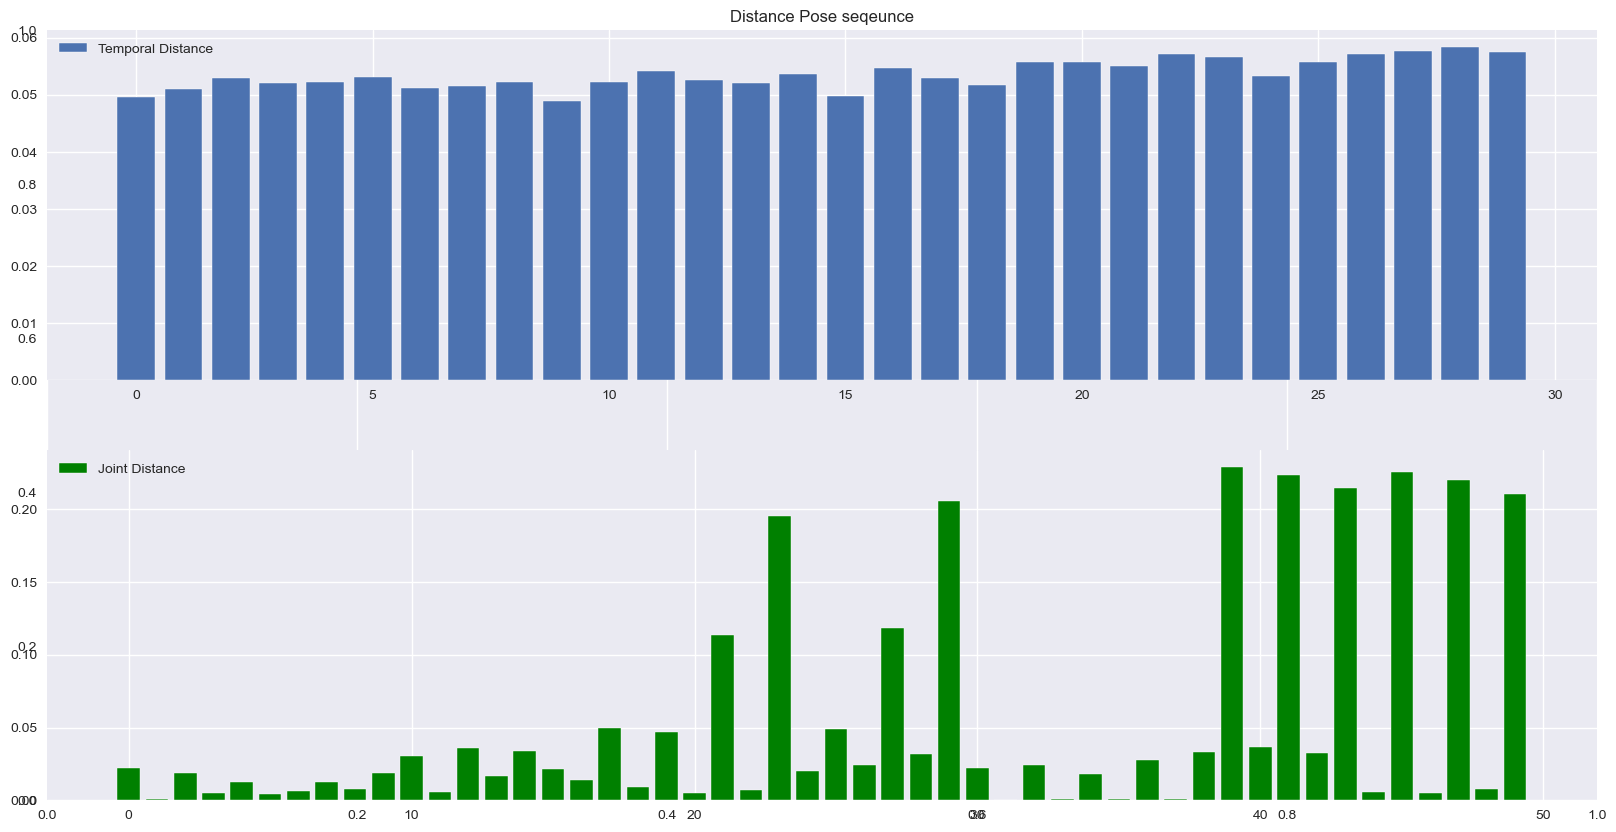

In [112]:
## Your should only run this cell after completing the exercise above
method_of_adjustment = adjusted_data1 #My method for easily changing which method i want to see

Dist1 = MSE(method_of_adjustment,GT_poses)
plt.figure(figsize=(20,10))
plt.title('Distance Pose seqeunce')
plt.subplot(2,1,1)
plt.bar(np.arange(len(Dist1)), Dist1, align='center',label='Temporal Distance')
plt.legend()
plt.subplot(2,1,2)
Dist2 = MSE(method_of_adjustment,GT_poses,avg='Joint')
plt.bar(np.arange(len(Dist2)), Dist2, align='center',color='green',label='Joint Distance')
plt.legend()

#### Plotting GT, noisy and adjusted poses


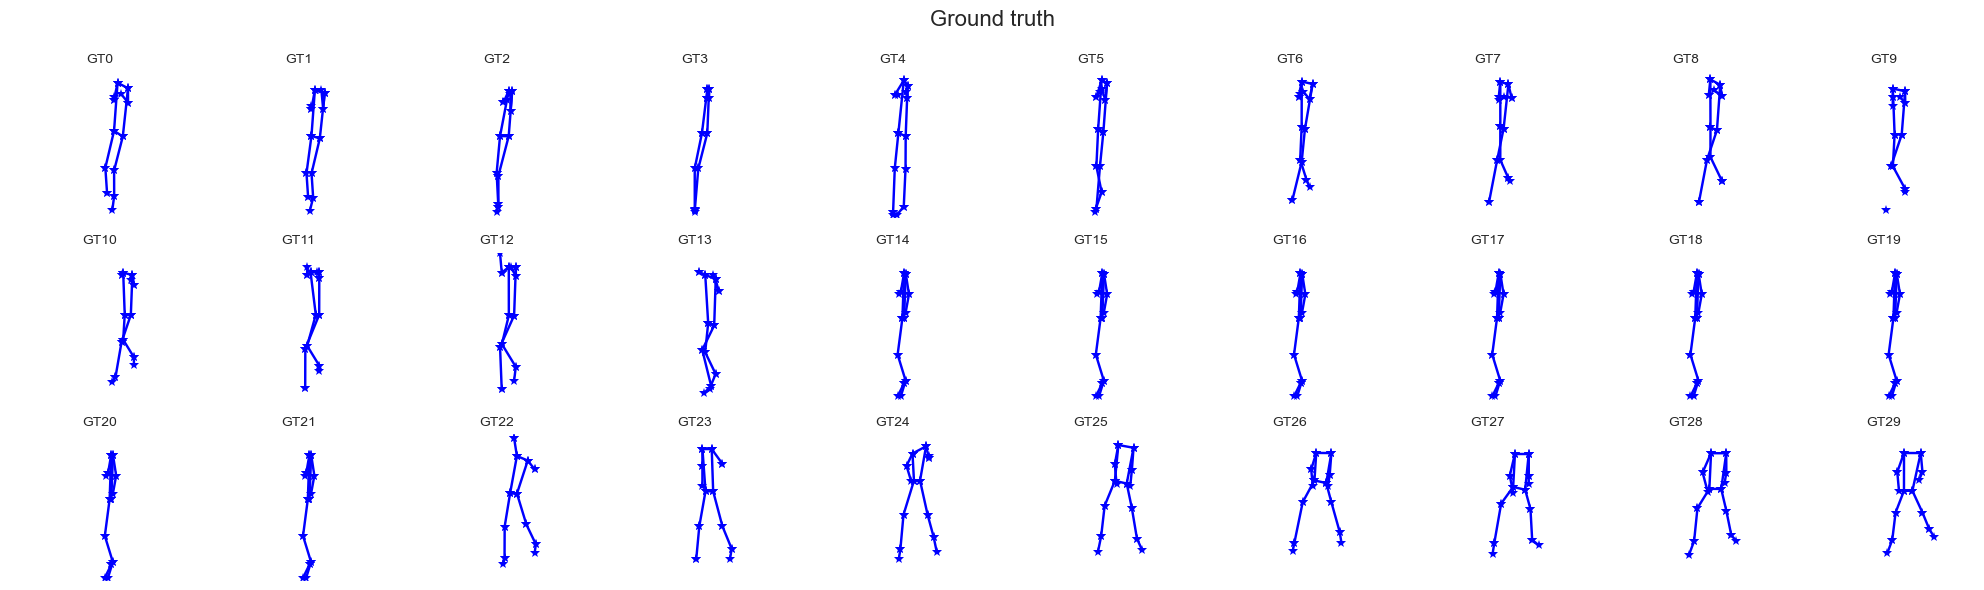

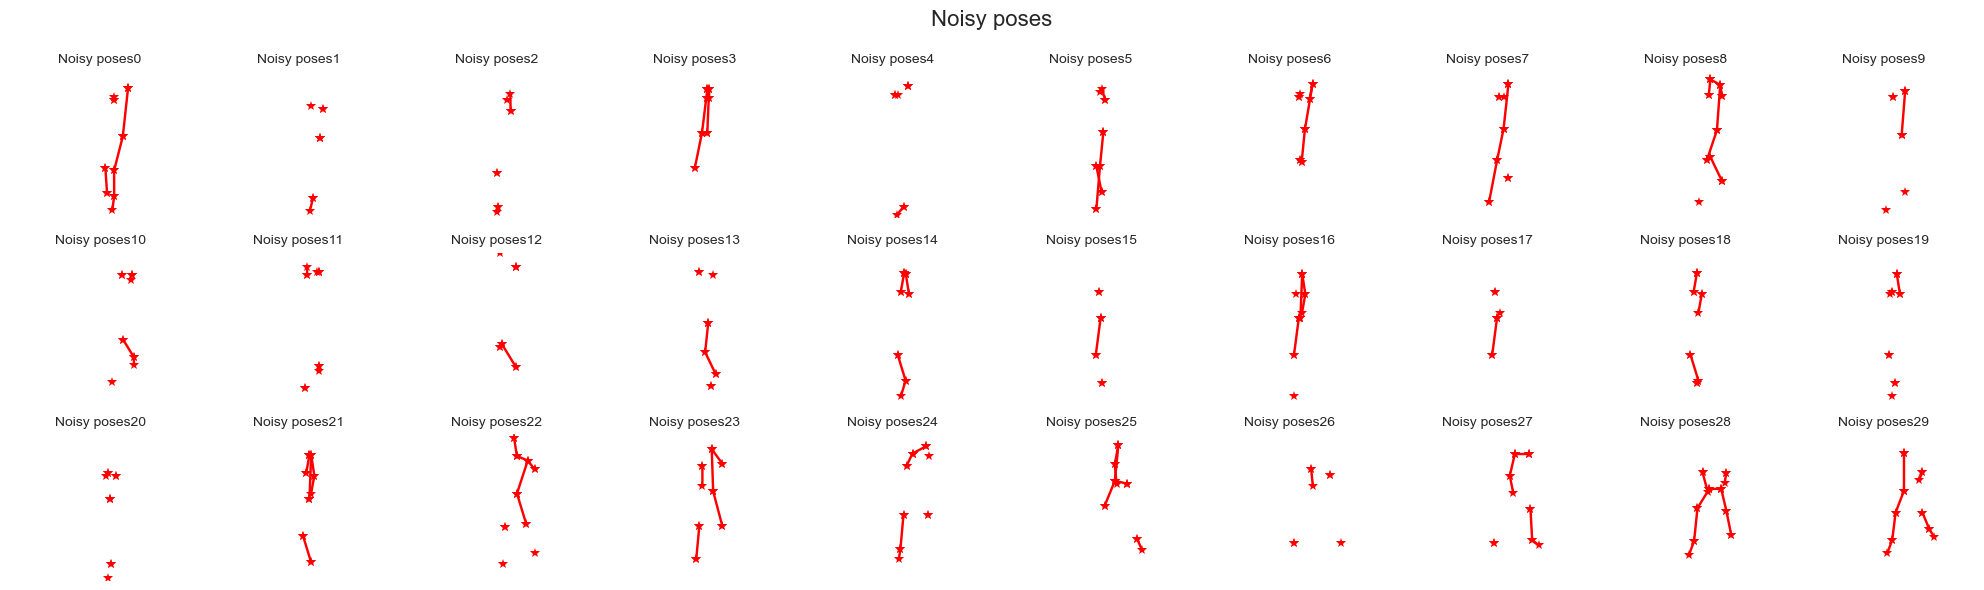

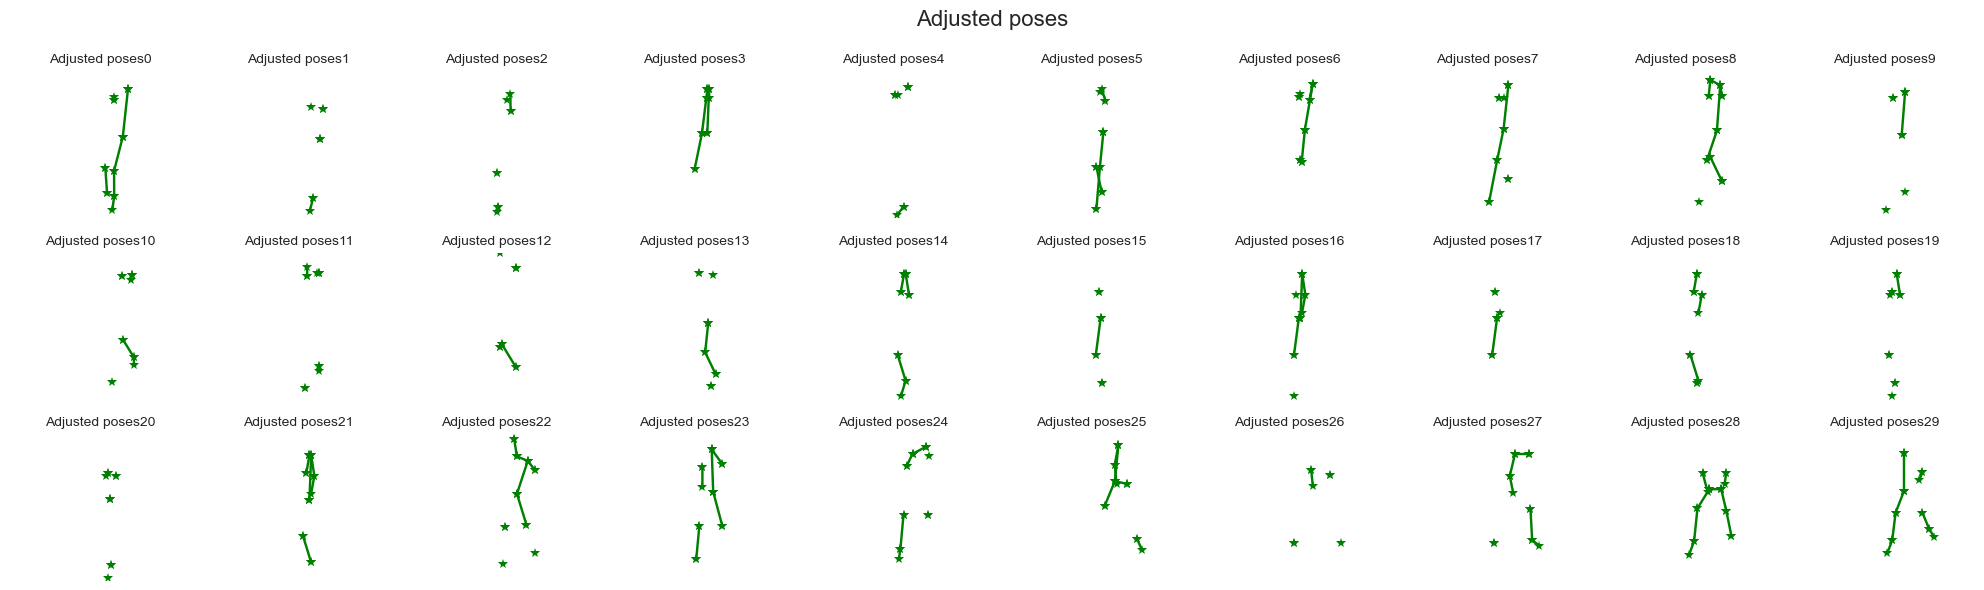

In [113]:
## Your should only run this cell after completing the exercise above
## Plot a random single sequence of the noisy, ground truth and adjusted skeleton data.
np.random.seed(42)
sample = np.random.randint(0,200)
plot_single_sequence(GT_poses[sample],pose_name='GT',color='blue')
plot_single_sequence(Noisy_poses[sample],pose_name='Noisy poses',color='red')
plot_single_sequence(method_of_adjustment[sample],pose_name='Adjusted poses',color='green')


---
**Task 5 (medium): Method comparison💡📽️**
1. Analyze the mean squared error (MSE), and inspect the adjusted pose sequences for each missing data approach and discuss the advantages and disadvantages of each method.


---

In [114]:
# the MSE values are lowest for method 3, ie. interpolation, which also makes sense, due to 
# this being the most advanced of the methods, and predicting for the next changes.

# the plots for method 3 are not far off the original, where it is almost unseeable 
# what it does for method 1, and method 2 just makes takes a guess that is not very showing
# of this data.

### Descriptive statistics for evaluating imputation method
As a final step, we need to evaluate how the missing value imputation procedure affects the statistical properties of the data. Specifically, we will focus on the mean and the covariance of both the original and the imputed poses.

---
**Task 6 (medium): Mean pose and pose sequence👩‍💻💡📽️**
The cell below contains code for plotting the original mean pose sequence. First run the cell, then modify the code to:
- Plot the mean sequence after filling in the missing values with zeros.
- Compare the two plots. Do you observe any differences? If yes, what could be the reason behind these differences and what insights can they provide regarding the characteristics of the mean?
- Plot the mean pose (not a sequence of poses, but a single pose) for the ground truth data and for the imputed datasets as well. Do you observe any differences between the mean pose (or the scale of the pose) in any of the plots?
- Based on the way in which the mean is calculated, is the mean sequence of poses or the mean pose more affected by the imputation process for missing data?


---

Plotting the mean sequence


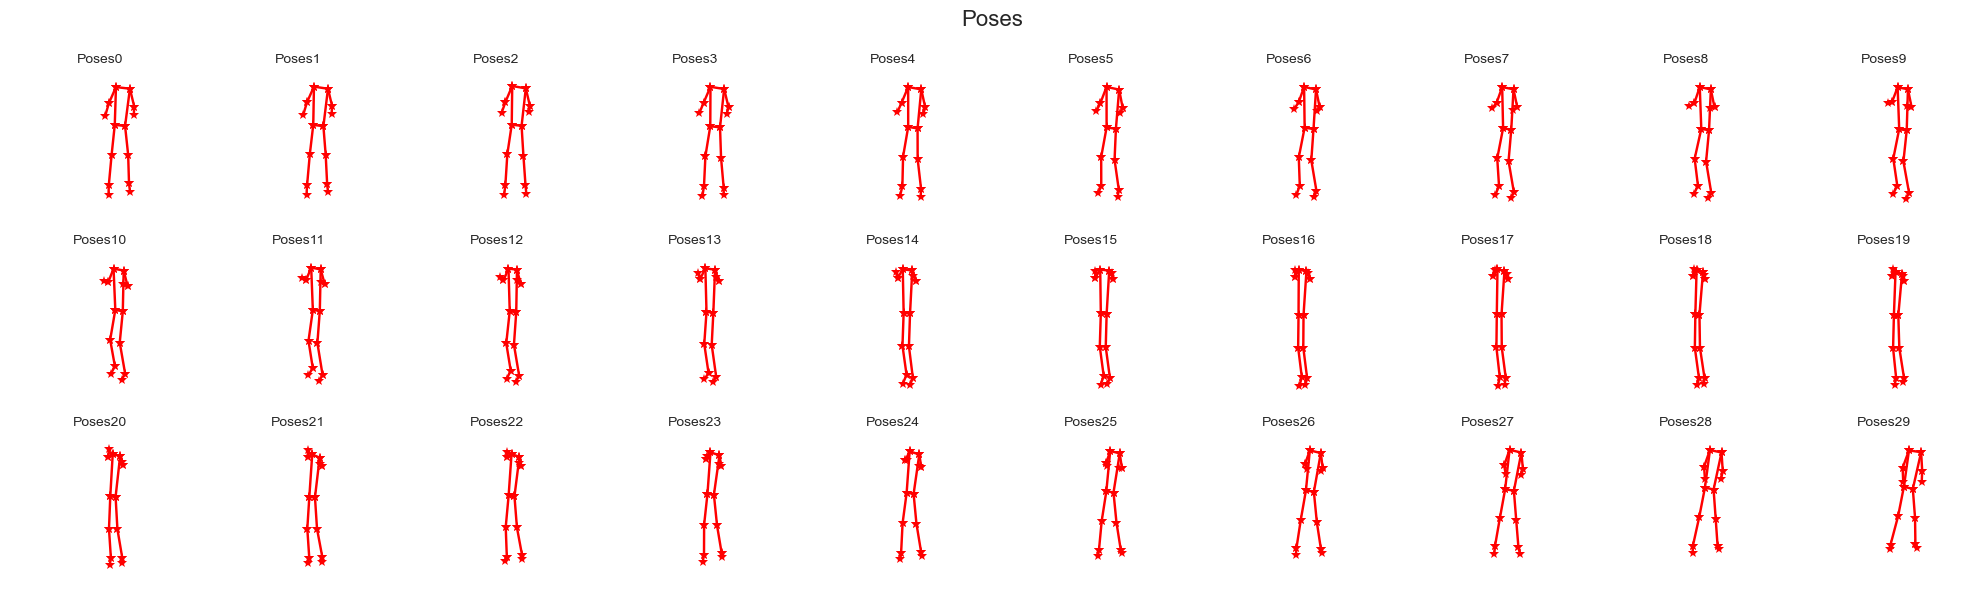

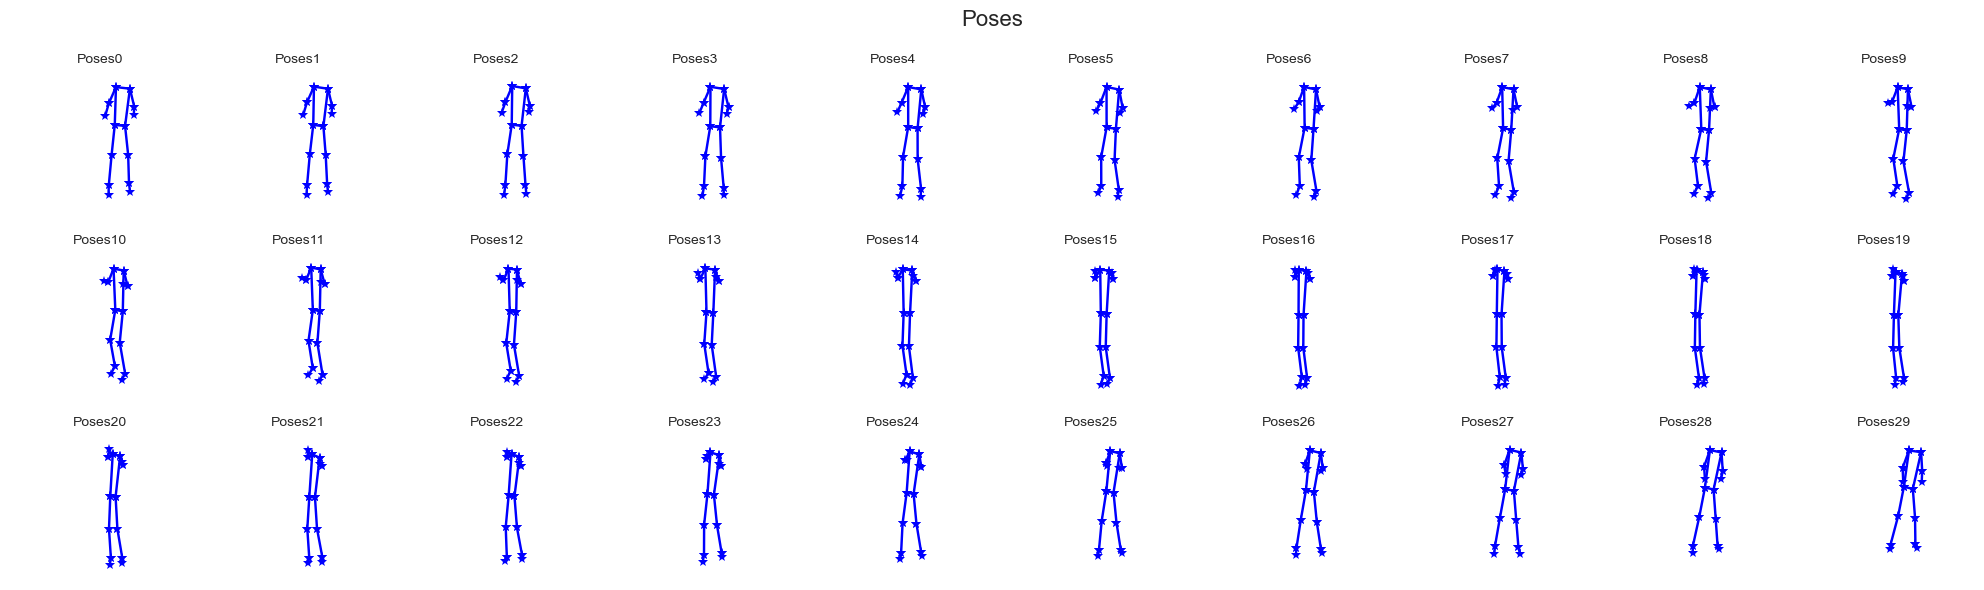

WE observe that it is not that far off, when just comparing from eyesight, for this specific mean.
 
Plot single pose:
Our adjusted data:


True

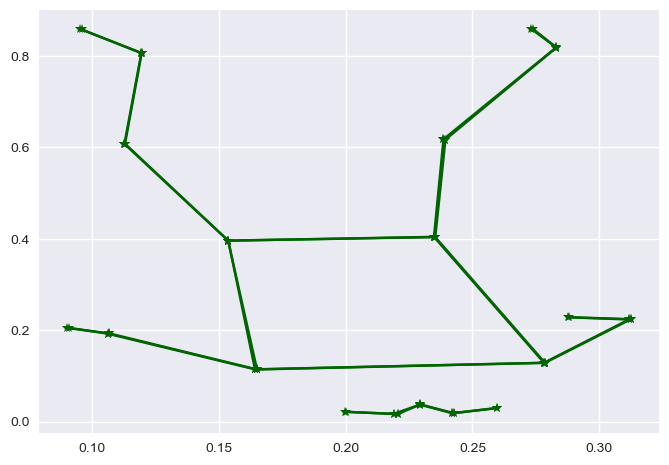

In [130]:
print("Plotting the mean sequence")
plot_single_sequence(GT_poses.mean(axis=(0)),color='red')
plot_single_sequence(filling_missing(GT_poses,0).mean(axis=(0)), color='blue')
print("WE observe that it is not that far off, when just comparing from eyesight, for this specific mean.")
print(" ")
# Your solution goes here
print("Plot single pose:")
plot_single_pose(GT_poses.mean(axis=(0)).mean(axis=(0)))
print("Our adjusted data:")
plot_single_pose(adjusted_data3.mean(axis=(0)).mean(axis=(0)))

# ????????????????????? I GIVE UP??????? IT DOES NOT PRINT OR MAKE SENSE WHAT WE SHOULD DO OR UNDERSTAND?????

In addition to analyzing the data's mean, we also need to investigate how the different imputation methods impact the relationship between variables. The tutorial demonstrated that correlation matrices are useful for quantifying how multiple variables co-vary. Throughout the next task we generate multiple correlation matrices to examine whether the relationship between features/joints is preserved by the way we handled missing data:

---
**Task 7 (easy): Correlation between features👩‍💻💡📽️**
This task is divided into multiple steps, as we need to construct and compare multiple correlation matrices:

**Info**
In the tutorial the correlation matrix was generated using the corr() function, which is exclusively applicable to Pandas DataFrames. In the current exercises we are working with a Numpy array. The correlation matrix for such an array can be obtained using the np.corrcoef() function.


The cell below contains code for pre-processing the ground truth dataset and constructing the correlation matrix:
1. Run the code and modify it to obtain a correlation matrix for each of the imputed datasets.
2. Compare the correlation matrices:    - Do any of the imputation methods preserve the original relationships between joints?
    - Does it have any significance whether the original relationship is preserved?


3. Based on the MSE scores, the visual inspection, and the inspection of statistical properties, which imputation method would you chose for the current dataset and why? List at least 5 different reasons for your choice.


---

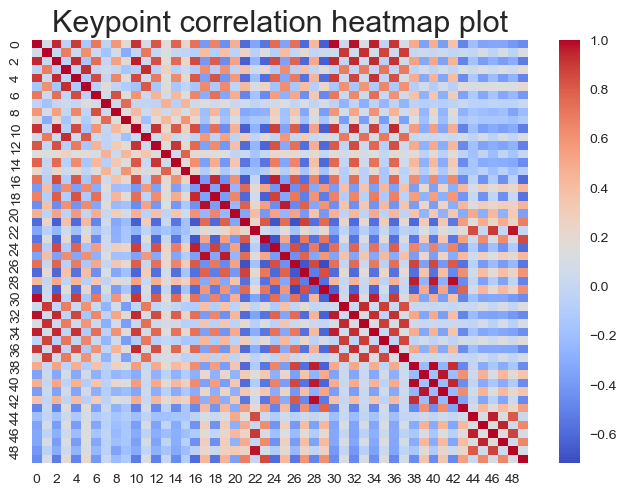

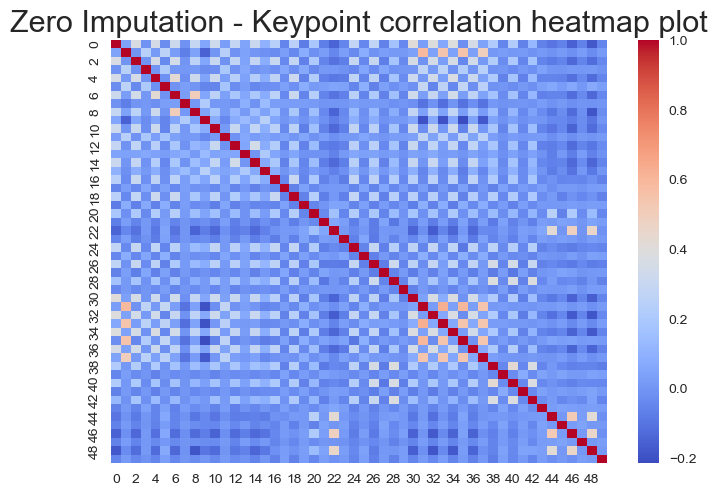

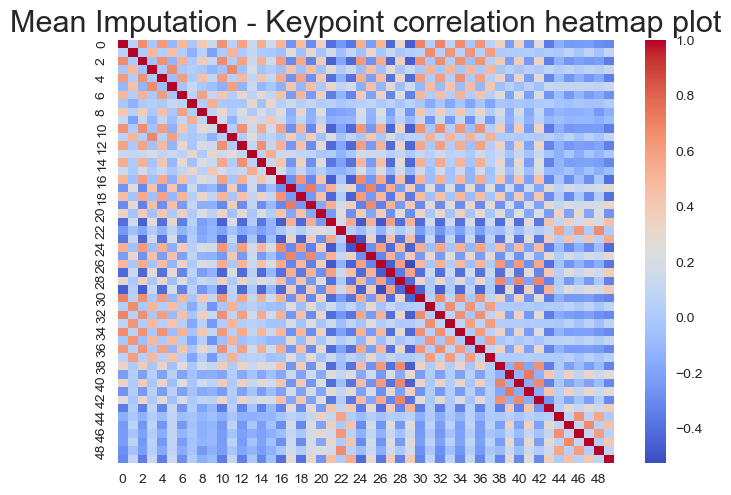

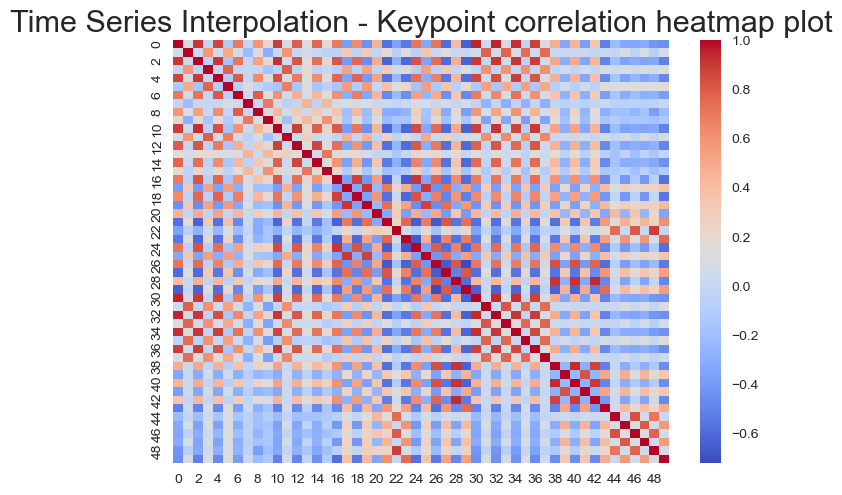

In [132]:
# pre-processing the data: flattening and transposing all of the ground truth poses
GT_poses_reshaped = GT_poses.reshape(-1,50)[:].T

GT_poses_reshaped_only_x = GT_poses.reshape(-1,50)[:,::2].T
GT_poses_reshaped_only_y = GT_poses.reshape(-1,50)[:,1::2].T

# Generating the correlation matrix
plt.title('Keypoint correlation heatmap plot',fontsize=22)
sns.heatmap(np.corrcoef(GT_poses_reshaped),cmap='coolwarm')
plt.show()

# ===== ZERO IMPUTATION =====
zero_poses_reshaped = adjusted_data1.reshape(-1, 50)[:].T

plt.title('Zero Imputation - Keypoint correlation heatmap plot', fontsize=22)
sns.heatmap(np.corrcoef(zero_poses_reshaped), cmap='coolwarm')
plt.show()

# ===== MEAN IMPUTATION =====
mean_poses_reshaped = adjusted_data2.reshape(-1, 50)[:].T

plt.title('Mean Imputation - Keypoint correlation heatmap plot', fontsize=22)
sns.heatmap(np.corrcoef(mean_poses_reshaped), cmap='coolwarm')
plt.show()

# ===== TIME SERIES INTERPOLATION =====
ts_poses_reshaped = adjusted_data3.reshape(-1, 50)[:].T

plt.title('Time Series Interpolation - Keypoint correlation heatmap plot', fontsize=22)
sns.heatmap(np.corrcoef(ts_poses_reshaped), cmap='coolwarm')
plt.show()

In [ ]:
# Recommended Method: Time Series Interpolation

# Richest correlation structure preserved: The Time Series plot shows the most complex patterns with clear block 
#                                           structures and varied correlations (reds, oranges, blues), similar to 
#                                           what you'd expect in real motion data where joint movements are interdependent.
# Avoids artificial uniformity: Zero Imputation shows mostly uniform blue (weak correlations), indicating it flattened 
#                                           the natural relationships between keypoints by introducing zeros that don't 
#                                           reflect actual motion patterns.
# More natural variation: Mean Imputation shows some structure but with less definition than Time Series - the correlation 
#                                           patterns are more washed out, suggesting it averages away important temporal dependencies.
# Respects temporal continuity: Time Series Interpolation maintains the sequential nature of motion data, creating 
#                                           correlations that reflect how joints move together over time, not just static 
#                                           statistical relationships.
# Clear block diagonal patterns: The Time Series plot shows distinct clustered correlations (block patterns), indicating 
#                                           it preserved the natural grouping of related joints (e.g., arm joints correlating 
#                                           with each other), which is biomechanically realistic for motion capture data.

# Visual Evidence: Time Series has the most "structure" - the patterns 
# aren't too uniform (like Zero) or too smoothed (like Mean), suggesting it best 
# captures the true complexity of joint relationships.